For sanity checking that overfitting on a single batch works

Note:
Overfitting "too much" will result with large difference in train and evalution mode because of batchnorm and whatnot

In [1]:
from typing import Generic, Optional, Tuple, List, Callable, Iterable, Mapping

import numpy as np
from torchvision.models import resnet50
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import utils
from utils import debugt, debugs, debug

torch.hub.set_dir('torch_cache')
import fishdetr_batchboy as detr
import contextlib
from generators import TorchStereoDataset
import re
from matplotlib import pyplot as plt
import plotly.express as px

import sys
sys.path.append('./detr_custom/')
from models.matcher import HungarianMatcher
from models.detr import SetCriterion
import os

In [2]:
debugt = utils.reloader(debugt)

In [3]:
utils.seed_everything(42069)

try:
    device = utils.pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
    print(utils.get_cuda_status(device))
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)
GeForce RTX 2080 Ti 
Memory usage:
Allocated: 0.0 GB
Cached   : 0.0 GB


In [4]:
DATA_DIR = '/mnt/blendervol/leftright_left_data'
TABLE = 'bboxes_std'
BATCH_SIZE = 4

In [21]:
traingen = TorchStereoDataset(DATA_DIR, TABLE, shuffle=False, imgnrs=range(32,32+BATCH_SIZE))

loader = torch.utils.data.DataLoader(
    traingen,
    batch_size=BATCH_SIZE,
    collate_fn=detr.collate
)

X, y = next(iter(loader))
X, y = detr.preprocess(X, y, device)

In [6]:
debugs(X[0])

(1, <module>) X[0]: torch.Size([4, 3, 416, 416])


In [7]:
model = detr.FishDETR(freeze_encoder=False).to(device)

Encoder successfully loaded with pretrained weights


In [13]:
@utils.interruptable
def train(model: nn.Module, X: detr.StereoImgs, y: detr.DETROutput, epochs: int=1):    
    weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']
    matcher = HungarianMatcher()
    criterion = SetCriterion(6, matcher, weight_dict, 0.5, losses).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1, verbose=False)
    
    model.train()
    criterion.train()
    
    for epoch in range(1,epochs+1):
        output, loss = model.train_on_batch(X, y, criterion, optimizer)
        scheduler.step()
        loss: torch.Tensor
        if not epoch % 10:
            print(loss.item())
    return output


def load_and_eval(model: nn.Module, X: detr.StereoImgs, y: detr.DETROutput):
    model.load_state_dict(torch.load('batch_overfit.pth'))
    weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']
    matcher = HungarianMatcher()
    criterion = SetCriterion(6, matcher, weight_dict, 0.5, losses).to(device)
    output, loss = model.eval_on_batch(X, y, criterion, True)
    print("Loss: ", loss.item())
    return output
    
# output = train(model, X, y, 500)
output = load_and_eval(model, X, y)

Loss:  0.10123903304338455


In [14]:
num2name = eval(open(os.path.join(DATA_DIR,"metadata.txt"), 'r').read())

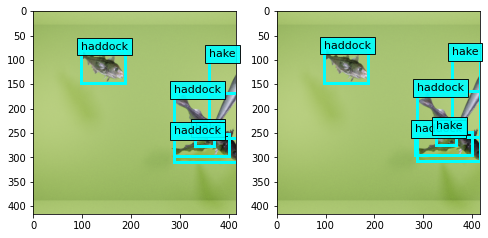

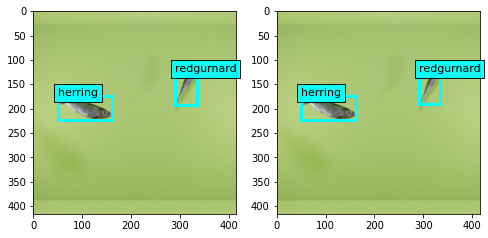

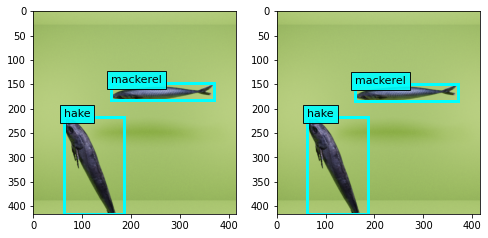

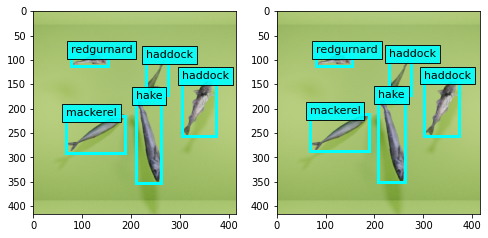

In [19]:
model.forward_and_plot(X, y, figsize=(8,4), classmap=num2name)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [12]:
raise ValueError

ValueError: 

In [ ]:
def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def plot_results(img, classes: Iterable, boxes: Iterable, classmap: Optional[Mapping[int, str]]=None, ax: Optional=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16,10))
        
    img = np.array(img)
    ax.imshow(img.clip(0,1))
    
    if len(boxes) != 0:
        h, w = img.shape[:2]
        boxes = box_cxcywh_to_xyxy(boxes)
        boxes[:,[0,2]] *= w
        boxes[:,[1,3]] *= h
        
        for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='cyan', linewidth=3))
            try:
                strcls = classmap[int(cls)]
            except:
                strcls = str(int(cls))
                    
            ax.text(xmin, ymin, strcls, fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
    
    if ax is None:
        ax.axis('off')
        plt.show()
        
    return ax


@torch.no_grad()
def eval_model(model, X: Tuple[torch.Tensor, torch.Tensor], classmap: Optional[Mapping[int, str]]=None, ax: Optional=None):
    model.eval()
    
    output = model(X)
    boxes = output['pred_boxes'][0]
    logits = output['pred_logits'][0]

    logits_, boxes_ = detr.postprocess(logits, boxes, thresh=0.1)

    plot_results(img[0][0].cpu().numpy().transpose((1,2,0)), logits_, boxes_, classmap, ax=ax)
        
        
def eval_compare_model(model: nn.Module, gen: Iterable, index: int=0, classmap: Optional[Mapping[int, str]]=None):
    x, y = gen[index]
    fig, axes = plt.subplots(1,2,figsize=(15,7))
    eval_model(model, detr.img_handler([x])[0], classmap, axes[0])
    plot_results(x[0][0].cpu().numpy().transpose((1,2,0)), y['labels'], y['boxes'], classmap, axes[1])
    axes[0].set_title('Predicted')
    axes[1].set_title('Real')
    

num2name = eval(open(os.path.join(DATA_DIR,"metadata.txt"), 'r').read())
model.eval()
for i in range(BATCH_SIZE):
    eval_compare_model(model, traingen, index=i, classmap=num2name)
    plt.show()
    